# sacc Examples


In [1]:
pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyccl as ccl
import sacc
import sys
import datetime
from astropy.io import fits
import time

In [3]:
nbin = 4

# Getting input data

We will make some fake window ranges and data vectors from theory predictions using CCL.  We will also need fake N(z) distributions in that case.

In [4]:
galaxy_density_cl = sacc.standard_types.galaxy_density_cl

ell_edges = np.linspace(5, 10000, 20).astype(int)
window_ranges = list(zip(ell_edges[:-1], ell_edges[1:]))
effective_ell = np.array([mean(x) for x in window_ranges])
ell_max = window_ranges[-1][-1]+1


CPU times: user 3.96 s, sys: 26.4 ms, total: 3.99 s
Wall time: 1.38 s


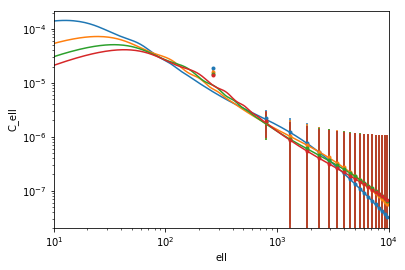

In [5]:
%%time
cosmo = ccl.Cosmology(Omega_c=0.25, Omega_b=0.05, h=0.72, n_s=0.96, A_s=2.1e-9)
N_z = []
spectra = []
errors = []
z = np.arange(0., 3.0, 0.01)
for i in range(nbin):
    mean_z = 0.3*(1+i)
    sigma_z = 0.05
    n_z = np.exp(-0.5*(z - mean_z)**2 / sigma_z**2)
    N_z.append(n_z)
    
    bias = np.ones_like(z) * 1.5*(mean_z/0.3)**0.5
    T = ccl.NumberCountsTracer(cosmo, False, (z,N_z[i]), (z, bias))
    ell = np.arange(ell_max+1)
    cl = ccl.angular_cl(cosmo, T, T, ell)
    cb = []
    for m,M in window_ranges:
        cb.append(np.mean(cl[m:M]))
    spectra.append(cb)
    errors.append(np.ones_like(cb)*1e-6)
    line, = loglog(ell, cl)
    errorbar(effective_ell, cb, yerr=errors[-1], fmt='.', color=line.get_color())
    xlim(10,ell_max)
    xlabel("ell")
    ylabel("C_ell")

    

# Constructing the data set object

We now construct the Sacc data set object, using all the different ingredients.

In [6]:
timer = time.perf_counter

S = sacc.Sacc()

S.metadata['nbin_lens'] = 4
S.metadata['nbin_source'] = 0 
S.metadata['creator'] = 'Beloved User'
S.metadata['creation'] = datetime.datetime.now().isoformat()
S.metadata['info'] = 'Theory predictions using CCL'


t0 = timer()
# In this case we use the same top-hat window for each bin.
# In reality we would probably use a different window for each
# pair of bins, empirically determined.
windows = [sacc.TopHatWindow(m,M) for m,M in window_ranges]

# Imaginary new statistic's window that I just made up
windows_1pt = []
for i in range(5):
    v = np.arange(i*10., (i+1)*10.)
    w = np.random.uniform(size=10)**2
    windows_1pt.append(sacc.Window(v,w))

t1 = timer()
variances = []

for i in range(nbin):
    # Add the appropriate tracer
    S.add_tracer('NZ', f'bin_{i}', z, N_z[i])
    # Get the binned spectrum values
    cb = spectra[i]
    # In this case we are just doing LSS, so
    # there is just a single bin, repeated.
    bin_name = f'bin_{i}'
    # Add the values
    S.add_ell_cl(galaxy_density_cl, bin_name, bin_name, effective_ell, cb, window=windows)
    variances.append(errors[i]**2)
    # Imaginary statistic to test having a second kind of data here
    for i in range(10):
        S.add_data_point('galaxy_density_1pt', (bin_name,), 1.0*np.sqrt(i),
                         window=windows_1pt[i%5], is_good=np.random.choice([0,1]))
        variances.append([1.0])

t2 = timer()
S.add_covariance(np.concatenate(variances))
t3 = timer()

# The canonical ordering organizes data points by type
#S.to_canonical_order()
t4 = timer()


print("These times can vary a lot:")
print(f"    Time to make window objects: {(t1-t0)*1000:.2f}ms")
print(f"    Time to make tracers and data points: {(t2-t1)*1000:.2f}ms")
print(f"    Time to add covariance: {(t3-t2)*1000:.2f}ms")
print(f"    Time to sort data: {(t4-t3)*1000:.2f}ms")
print(f"    Total construction time: {(t4-t0)*1000:.2f}ms")


S.data[4].tags['magic_number'] = 42
S.data[10].tags['magic_number'] = 42


These times can vary a lot:
    Time to make window objects: 0.77ms
    Time to make tracers and data points: 1.91ms
    Time to add covariance: 0.17ms
    Time to sort data: 0.02ms
    Total construction time: 2.87ms


In [7]:
# An example cut
cut = S.indices("galaxy_density_cl", ell__gt=9000)
print(f"Removing {len(cut)} data points")
S.remove_indices(cut)

# Could also write this to do the cut directly
S.remove_selection('galaxy_density_cl', ell_gt=8000)


Removing 8 data points


/Users/jaz/src/Sacc/sacc/sacc.py:341: UserWarning: Empty index selected
  warnings.warn("Empty index selected")


# I/O

Let's save to a FITS file now and reload.

In [8]:
S.save_fits('tmp.fits', overwrite=True)

In [9]:
S2 = sacc.Sacc.load_fits('tmp.fits')

# Plotting

Let's plot the original data file and the re-loaded one, to check they agree.

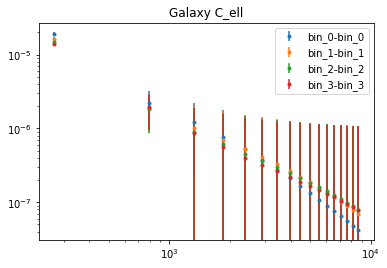

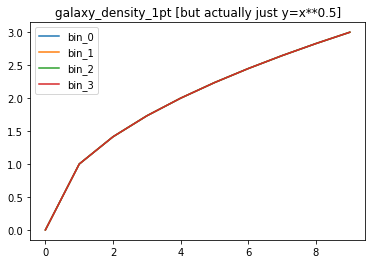

In [10]:
# #plot our other kind of weird pretend statistic
for b1, b2 in S.get_tracer_combinations('galaxy_density_cl'):
    ell, cl, covmat = S.get_ell_cl('galaxy_density_cl', b1, b2, return_cov=True)
    errorbar(ell, cl, yerr=covmat.diagonal()**0.5, fmt='.', label=f'{b1}-{b2}')
    xscale('log')
    yscale('log')
title("Galaxy C_ell")
legend()

figure()
#plot our other kind of weird pretend statistic
for tracers in S.get_tracer_combinations('galaxy_density_1pt'):
    mu = S2.get_mean('galaxy_density_1pt', tracers)
    plot(mu, label=str(tracers[0]))
title("galaxy_density_1pt [but actually just y=x**0.5]")
legend()

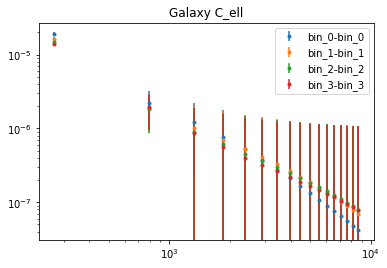

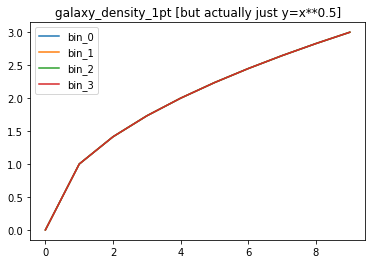

In [11]:
# #plot our other kind of weird pretend statistic
for b1, b2 in S2.get_tracer_combinations('galaxy_density_cl'):
    ell, cl, covmat = S2.get_ell_cl('galaxy_density_cl', b1, b2, return_cov=True)
    errorbar(ell, cl, yerr=covmat.diagonal()**0.5, fmt='.', label=f'{b1}-{b2}')
    xscale('log')
    yscale('log')
title("Galaxy C_ell")
legend()

figure()
#plot our other kind of weird pretend statistic
for tracers in S2.get_tracer_combinations('galaxy_density_1pt'):
    mu = S2.get_mean('galaxy_density_1pt', tracers)
    plot(mu, label=str(tracers[0]))
title("galaxy_density_1pt [but actually just y=x**0.5]")
legend()

# Supernova Example

Let's do a very different kind of example - a supernova file containing
1 million supernovae.  This isn't really what the format was designed for,
but would provide a somewhat plausible extreme case.

In [12]:
%%time
S3 = sacc.Sacc()
N = 1000000
S3.add_tracer('misc', 'SN_pop1')
for i in range(N):
    S3.add_data_point("supernova_data", ('SN_pop1',), np.random.uniform(14., 26.), z=np.random.uniform(0., 3.0))

CPU times: user 5.13 s, sys: 164 ms, total: 5.29 s
Wall time: 5.29 s


In [13]:
%%time
S3.to_canonical_order()

CPU times: user 1.77 s, sys: 97.8 ms, total: 1.87 s
Wall time: 1.87 s


In [14]:
%%time
z=S3.get_tag('z', 'supernova_data')

CPU times: user 1.16 s, sys: 57.6 ms, total: 1.22 s
Wall time: 1.22 s


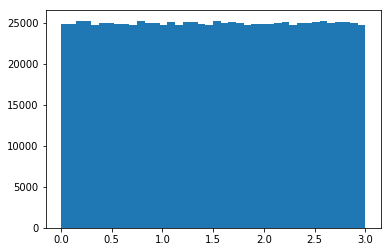

In [15]:
_=hist(z, bins=40)


In [16]:
# This is too slow, and if data this size becomes a real use case for the format
# then we shouldd re-write things, but we don't expect that.
%time S3.save_fits("sn.fits", overwrite=True)

CPU times: user 30.7 s, sys: 812 ms, total: 31.6 s
Wall time: 31.7 s


In [17]:
%time S4 = sacc.Sacc.load_fits("sn.fits")

CPU times: user 14.7 s, sys: 279 ms, total: 14.9 s
Wall time: 14.9 s
